In [22]:
from Crypto.PublicKey import ECC
from Crypto.Cipher import AES
from Crypto.Protocol.KDF import HKDF
from Crypto.Hash import SHA256
import time
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# Geração das chaves ECC
key = ECC.generate(curve='P-256')
private_key = key
public_key = key.public_key()

In [24]:
with open("ecc_private.pem", "wt") as f:
    f.write(private_key.export_key(format='PEM'))

with open("ecc_public.pem", "wt") as f:
    f.write(public_key.export_key(format='PEM'))

# Criptografia

In [25]:
tempos_execucao = []
execucoes = []

for rodagem in range(218, 300):
    inicio = time.perf_counter()
    print(f'Iniciando criptografia ECC: arquivo {rodagem}')

    dicom_path = f'C:\\Users\\CarlosChinen\\OneDrive\\Main\\FEI\\TCC\\Criptografia\\criptografia\\dicom_fourier_spectrum_dataset\\spectrum_slice_{rodagem}.png'

    with open(dicom_path, "rb") as dicom_file:
        image_data = dicom_file.read()

    # ECC key agreement (ECDH) - cria uma chave secreta compartilhada
    ephemeral_key = ECC.generate(curve='P-256')
    shared_secret = ephemeral_key.d * public_key.pointQ

    # Deriva uma chave AES a partir do segredo compartilhado
    shared_secret_bytes = int(shared_secret.x).to_bytes(32, byteorder='big')
    aes_key = HKDF(shared_secret_bytes, 32, b'', SHA256)

    cipher_aes = AES.new(aes_key, AES.MODE_EAX)
    ciphertext, tag = cipher_aes.encrypt_and_digest(image_data)

    # Armazena: chave pública efêmera, nonce, tag e dados criptografados
    with open(f"ECIES_crypto_spectrum_metrics/ECIES_spectrum_criptografado_{rodagem}.enc", "wb") as out_file:
        out_file.write(ephemeral_key.public_key().export_key(format='DER'))
        out_file.write(cipher_aes.nonce)
        out_file.write(tag)
        out_file.write(ciphertext)

    fim = time.perf_counter()
    tempo_execucao = fim - inicio
    tempos_execucao.append(tempo_execucao)
    execucoes.append(rodagem)

    print(f'Criptografia ECC finalizada: arquivo {rodagem}')
    print(f"Tempo de execução: {tempo_execucao:.5f} segundos\n")

print(f'\nTempo médio de execução: {np.mean(tempos_execucao):.5f}')

Iniciando criptografia ECC: arquivo 218
Criptografia ECC finalizada: arquivo 218
Tempo de execução: 0.00282 segundos

Iniciando criptografia ECC: arquivo 219
Criptografia ECC finalizada: arquivo 219
Tempo de execução: 0.00263 segundos

Iniciando criptografia ECC: arquivo 220
Criptografia ECC finalizada: arquivo 220
Tempo de execução: 0.00224 segundos

Iniciando criptografia ECC: arquivo 221
Criptografia ECC finalizada: arquivo 221
Tempo de execução: 0.00224 segundos

Iniciando criptografia ECC: arquivo 222
Criptografia ECC finalizada: arquivo 222
Tempo de execução: 0.00286 segundos

Iniciando criptografia ECC: arquivo 223
Criptografia ECC finalizada: arquivo 223
Tempo de execução: 0.00224 segundos

Iniciando criptografia ECC: arquivo 224
Criptografia ECC finalizada: arquivo 224
Tempo de execução: 0.00254 segundos

Iniciando criptografia ECC: arquivo 225
Criptografia ECC finalizada: arquivo 225
Tempo de execução: 0.00263 segundos

Iniciando criptografia ECC: arquivo 226
Criptografia ECC

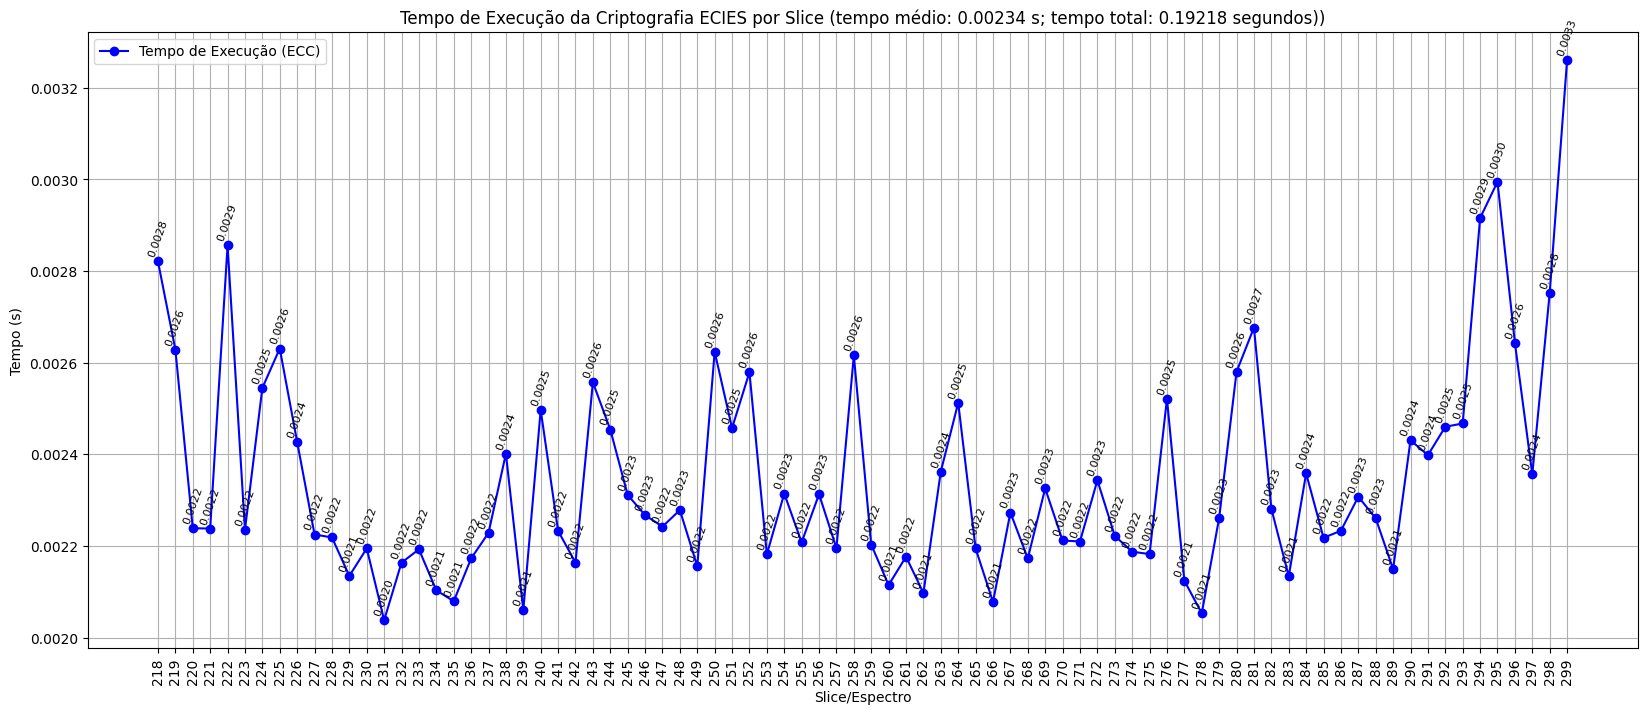

In [27]:
plt.figure(figsize=(20, 8))
plt.plot(execucoes, tempos_execucao, marker='o', linestyle='-', color='blue', label='Tempo de Execução (ECC)')

for x, y in zip(execucoes, tempos_execucao):
    plt.text(x, y + 0.00005, f'{y:.4f}', ha='center', va='center', fontsize=8, rotation=70)

plt.xticks(execucoes, rotation=90)
plt.xlabel('Slice/Espectro')
plt.ylabel('Tempo (s)')
plt.title(f'Tempo de Execução da Criptografia ECIES por Slice (tempo médio: {np.mean(tempos_execucao):.5f} s; tempo total: {np.sum(tempos_execucao):.5f} segundos))')
plt.legend()
plt.grid(True)
plt.savefig('output_images/graph_tempo_execucao_ecc_criptografia_espectro.png')
plt.show()